In [1]:
import torch

In [2]:
class PositionalEncoder(torch.nn.Module):
    def __init__(self, max_seq_len, d_model):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.d_model = d_model

        self.pe = torch.zeros(self.max_seq_len, self.d_model)

        # positional encoder 
        for j in range(max_seq_len):
            for i in range(0, d_model):
                if i%2 == 0:
                    k = i//2
                    wk = 1 / (10000**((2*k)/d_model))
                    self.pe[j][i] = torch.sin(torch.tensor(wk*j))
                else:
                    self.pe[j][i] = torch.cos(torch.tensor(wk*j))

        self.pe = self.pe.detach()

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)

        if x.shape[1]>self.max_seq_len:
            raise Exception("Number of tokens exceeds max_seq_len")
        
        if x.shape[2] != self.d_model:
            raise Exception("Token dimension do not match model dimension")
        
        if x.device != self.pe.device:
            self.pe = self.pe.to(x.device)  # Move pe to the same device as x

        x = x + self.pe[:x.shape[1], :]
        return x

In [3]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self, d_model, d_ff):
        super().__init__()
        self.d_model = d_model
        self.d_ff = d_ff

        self.ff1 = torch.nn.Linear(self.d_model, self.d_ff)
        self.ff2 = torch.nn.Linear(self.d_ff, self.d_model)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
            print("Warning: batch size not present")

        if x.shape[2]!=self.d_model:
            raise Exception("Token dimension do not match model dimension")
        
        x = self.ff1(x)
        x = self.ff2(x)

        return x

In [4]:
class LayerNorm(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.layerNorm = torch.nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.layerNorm(x)
        return x

In [5]:
class SelfAttentionHead(torch.nn.Module):
    def __init__(self, d_model, d_k, max_seq_len):
        super().__init__()
        self.d_model = d_model
        self.d_k = d_k
        self.max_seq_len = max_seq_len
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.W_q = torch.nn.Linear(in_features=d_model, out_features=d_k)
        self.W_k = torch.nn.Linear(in_features=d_model, out_features=d_k)
        self.W_v = torch.nn.Linear(in_features=d_model, out_features=d_k)

        self.W_O = torch.nn.Linear(in_features = d_k, out_features=d_model)
        
    def forward(self, Q, K, V, mask = False):
        if len(Q.shape)==2:
            Q.unsqueeze(0)
            print("Warning: batch size not present")

        if len(K.shape)==2:
            K.unsqueeze(0)
            print("Warning: batch size not present")

        if len(V.shape)==2:
            V.unsqueeze(0)
            print("Warning: batch size not present")

        if Q.shape[1] > self.max_seq_len or V.shape[1]> self.max_seq_len or K.shape[1]>self.max_seq_len:
            raise Exception("Number of tokens exceed max sequence length")

        if Q.shape[2] != self.d_model or K.shape[2] != self.d_model or V.shape[2]!=self.d_model:
            raise Exception("Tokens dimension do not match model dimension")

        Q = self.W_q(Q)
        K = self.W_k(K)
        V = self.W_v(V)

        logits = (torch.matmul(Q, torch.transpose(K, 1, 2)) )/ (self.d_k ** 0.5)
        if mask is True:
            ones = torch.ones(Q.shape[0], Q.shape[1], Q.shape[1]).to(Q.device)
            mask = torch.tril(ones)
            logits = logits.masked_fill(mask == 0, -float('1e9'))

        scores = torch.nn.functional.softmax(logits, dim = 1)
        attention = torch.matmul(scores, V)

        output = self.W_O(attention)
        
        return output

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, num_heads, d_model, d_k, max_seq_len):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k=d_k
        self.max_seq_len = max_seq_len

        self.heads = torch.nn.ModuleList([SelfAttentionHead(d_model=self.d_model, d_k=self.d_k, max_seq_len=self.max_seq_len) for _ in range(num_heads)])

        self.W_O = torch.nn.Linear(num_heads*self.d_model, self.d_model)

    def forward(self, Q, K, V, mask = False):
        if len(Q.shape)==2:
            Q.unsqueeze(0)
            print("Warning: batch size not present")

        if len(K.shape)==2:
            K.unsqueeze(0)
            print("Warning: batch size not present")

        if len(V.shape)==2:
            V.unsqueeze(0)
            print("Warning: batch size not present")

        if Q.shape[1] > self.max_seq_len or V.shape[1]> self.max_seq_len or K.shape[1]>self.max_seq_len:
            raise Exception("Number of tokens exceed max sequence length")

        if Q.shape[2] != self.d_model or K.shape[2] != self.d_model or V.shape[2]!=self.d_model:
            raise Exception("Tokens dimension do not match model dimension")

        head_outputs = [head(Q, K, V, mask) for head in self.heads]
        concatenated = torch.cat(head_outputs, dim=-1)
        return self.W_O(concatenated)

In [6]:
class DecoderBlock(torch.nn.Module):
    def __init__(self, num_heads, d_model, d_k, d_ff, max_seq_len):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_ff = d_ff
        self.max_seq_len = max_seq_len

        self.multiHeadAttention = MultiHeadAttention(num_heads=self.num_heads, d_model=self.d_model, d_k=self.d_k, max_seq_len=self.max_seq_len)
        self.layerNorm = LayerNorm(d_model=self.d_model)
        self.ffnn = FeedForwardNN(d_model=self.d_model, d_ff=self.d_ff)

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
            print("Warning: batch size not present")

        if x.shape[2]!=self.d_model:
            raise Exception("Token dimension do not match model dimension")
        
        y = self.layerNorm(x)
        y = self.multiHeadAttention(y, y, y, True)

        x = x+y
        y = x

        y = self.layerNorm(y)
        y = self.ffnn(y)

        x = x+y
        return x

In [ ]:
class DecoderWrapper(torch.nn.Module):
    def __init__(self, num_heads, d_model, d_k, d_ff, max_seq_len, num_blocks, word_embedder = None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.d_k = d_k
        self.d_ff = d_ff
        self.max_seq_len = max_seq_len
        self.num_blocks = num_blocks
        self.word_embedder = word_embedder

        self.pe = PositionalEncoder(max_seq_len=self.max_seq_len, d_model=self.d_model)
        self.decoders = torch.nn.ModuleList([DecoderBlock(d_model=self.d_model, d_k=self.d_k, max_seq_len=self.max_seq_len, d_ff=self.d_ff, num_heads=self.num_heads) for _ in range(num_blocks)])

    def forward(self, x):
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
            print("Warning: batch size not present")
        
        if x.shape[1] > self.max_seq_len:
            print(x.shape)
            raise Exception("Number of tokens exceeds max sequence length")

        if self.word_embedder is not None:
            x = self.word_embedder(x)

        if x.shape[2]!=self.d_model:
            raise Exception("Token dimension do not match model dimension")

        x = self.pe(x)

        for block in self.decoders:
            x = block(x)
        
        return x

In [8]:
# ETTh1 benchmark

import pandas as pd

df = pd.read_csv("data/ETTh1.csv", index_col = "date")
df = df.astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17420 entries, 2016-07-01 00:00:00 to 2018-06-26 19:00:00
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HUFL    17420 non-null  float32
 1   HULL    17420 non-null  float32
 2   MUFL    17420 non-null  float32
 3   MULL    17420 non-null  float32
 4   LUFL    17420 non-null  float32
 5   LULL    17420 non-null  float32
 6   OT      17420 non-null  float32
dtypes: float32(7)
memory usage: 612.4+ KB


In [9]:
import numpy as np
class ETTh1Dataset(torch.utils.data.Dataset):
    def __init__(self, data, lookback):
        self.raw_data = data
        self.lookback = lookback
        self.X = []
        self.Y = []

        for i in range(len(self.raw_data)-lookback-1):
            self.X.append(torch.tensor(df.iloc[i:i+self.lookback, :].values))
            self.Y.append(torch.tensor(df.iloc[i+1:i+self.lookback+1, :].values))
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.X[idx], self.Y[idx])

transformer model:
NUM_HEADS = 3
MAX_SEQ_LEN = 336
D_MODEL = 7
D_K = 32
D_FF = 64
NUM_BLOCKS = 2
BATCH_SIZE = 16
LOOKBACK = 336

transformer model large:
NUM_HEADS = 10
MAX_SEQ_LEN = 500
D_MODEL = 7
D_K = 128
D_FF = 256
NUM_BLOCKS = 4
BATCH_SIZE = 16
LOOKBACK = 500

In [10]:
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_HEADS = 10
MAX_SEQ_LEN = 500
D_MODEL = 7
D_K = 128
D_FF = 256
NUM_BLOCKS = 4
BATCH_SIZE = 16
LOOKBACK = 500

model = DecoderWrapper(num_heads=NUM_HEADS, num_blocks=NUM_BLOCKS, d_model=D_MODEL, d_k=D_K, d_ff=D_FF, max_seq_len=MAX_SEQ_LEN).to(DEVICE)
model = torch.nn.DataParallel(model, device_ids=[0,1])
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_fn = torch.nn.MSELoss()

dataset = ETTh1Dataset(df, LOOKBACK)

train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size  # Remaining 20% for testing

# Define indices for train and test sets
train_indices = list(range(0, train_size))  
test_indices = list(range(train_size, len(dataset)))  

# Create subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

test_loss_history = []

# early stopping
PATIENCE = 4
patience_counter = 0
best_MSE = None
N_EPOCHS = 100

In [11]:
torch.cuda.empty_cache()

for epoch in range(N_EPOCHS):
    bar = tqdm(train_loader)
    model.train()
    for X_batch, y_batch in bar:
        # X_batch = [batch, num_tokens, dim_tokens]
        y_pred = model(X_batch.to(DEVICE))
        y_pred = y_pred.squeeze()
        loss = loss_fn(y_pred, y_batch.to(DEVICE))

        bar.set_description(f"Loss: {loss.item():.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    

    total_loss = 0.0
    num_samples = 0

    model.eval()
    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            y_pred = model(X_test_batch.to(DEVICE))
            y_pred = y_pred.squeeze()
            # test mse only on the feature we're interested in
            batch_test_loss = loss_fn(y_pred[:,:,6], y_test_batch[:,:,6].to(DEVICE))
            total_loss += batch_test_loss.item() * X_test_batch.size(0)
            num_samples += X_test_batch.size(0)
        test_mse = total_loss / num_samples
        test_loss_history.append(test_mse)

        # early stop condition
        if best_MSE is None or test_mse < best_MSE:
            best_MSE = test_mse
            patience_counter = PATIENCE
            torch.save(model.state_dict(), "./models/transformer_model_large.pt")
        else:
            patience_counter -= 1 
            if patience_counter == 0:
                break
    print("Epoch %d: test MSE %.4f" % (epoch, test_mse))


  0%|          | 0/846 [00:00<?, ?it/s]

Loss: 1.2594: 100%|██████████| 846/846 [03:52<00:00,  3.64it/s]


Epoch 0: test MSE 0.5167


Loss: 0.9655: 100%|██████████| 846/846 [03:48<00:00,  3.69it/s]


Epoch 1: test MSE 0.5249


Loss: 0.7133: 100%|██████████| 846/846 [03:45<00:00,  3.75it/s]


Epoch 2: test MSE 0.5632


Loss: 0.7483: 100%|██████████| 846/846 [03:46<00:00,  3.73it/s]


Epoch 3: test MSE 0.4534


Loss: 0.5981: 100%|██████████| 846/846 [03:47<00:00,  3.72it/s]


Epoch 4: test MSE 0.4468


Loss: 0.5517: 100%|██████████| 846/846 [03:49<00:00,  3.69it/s]


Epoch 5: test MSE 0.4834


Loss: 0.5481: 100%|██████████| 846/846 [03:49<00:00,  3.69it/s]


Epoch 6: test MSE 0.4044


Loss: 0.4927: 100%|██████████| 846/846 [03:47<00:00,  3.71it/s]


Epoch 7: test MSE 0.4016


Loss: 0.5743: 100%|██████████| 846/846 [03:48<00:00,  3.71it/s]


Epoch 8: test MSE 0.4121


Loss: 0.4591: 100%|██████████| 846/846 [03:49<00:00,  3.69it/s]


Epoch 9: test MSE 0.4609


Loss: 0.5621: 100%|██████████| 846/846 [03:49<00:00,  3.69it/s]


Epoch 10: test MSE 0.4228


Loss: 0.4968: 100%|██████████| 846/846 [03:49<00:00,  3.69it/s]


Epoch 11: test MSE 0.3994


Loss: 0.4563: 100%|██████████| 846/846 [03:48<00:00,  3.70it/s]


Epoch 12: test MSE 0.3646


Loss: 0.3960: 100%|██████████| 846/846 [03:49<00:00,  3.68it/s]


Epoch 13: test MSE 0.3851


Loss: 0.3684: 100%|██████████| 846/846 [03:48<00:00,  3.70it/s]


Epoch 14: test MSE 0.3663


Loss: 0.3850: 100%|██████████| 846/846 [03:49<00:00,  3.68it/s]


Epoch 15: test MSE 0.3448


Loss: 0.3864: 100%|██████████| 846/846 [03:50<00:00,  3.68it/s]


Epoch 16: test MSE 0.3836


Loss: 0.3833: 100%|██████████| 846/846 [03:48<00:00,  3.70it/s]


Epoch 17: test MSE 0.3800


Loss: 0.3703: 100%|██████████| 846/846 [03:48<00:00,  3.70it/s]


Epoch 18: test MSE 0.4752


Loss: 0.4077: 100%|██████████| 846/846 [03:49<00:00,  3.69it/s]


In [ ]:
# train trial 2 facendolo autoregressivo


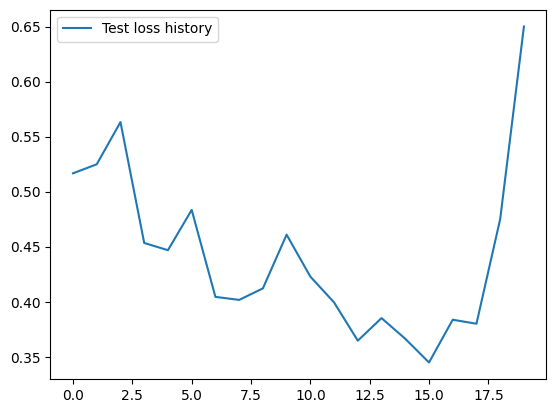

In [18]:
from matplotlib import pyplot as plt

plt.plot(range(0, len(test_loss_history)), test_loss_history, label="Test loss history")
plt.legend()
plt.show()

In [19]:
# model in memory 

torch.cuda.empty_cache()
model = DecoderWrapper(num_heads=NUM_HEADS, num_blocks=NUM_BLOCKS, d_model=D_MODEL, d_k=D_K, d_ff=D_FF, max_seq_len=MAX_SEQ_LEN).to(DEVICE)
model = torch.nn.DataParallel(model, device_ids=[0,1])
model.load_state_dict(torch.load("./models/transformer_model_large.pt", weights_only=True))

<All keys matched successfully>

In [20]:
# NOT autoregressive

y_pred_list = []

model.eval()
with torch.no_grad():
    for X_test_batch, y_test in test_loader:
        y_pred = model(X_test_batch.to(DEVICE))
        y_pred = y_pred.squeeze()
        y_pred_list.append(y_pred[:,LOOKBACK-1,6].cpu())

y_pred_list = torch.cat(y_pred_list, dim=0)
bootstrap = LOOKBACK+1
y_pred_list = torch.cat((torch.zeros(bootstrap), y_pred_list), dim=0) # bootstrap di 337 elementi

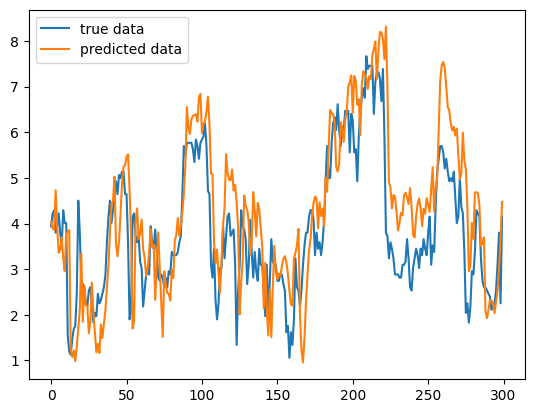

In [21]:
from matplotlib import pyplot as plt
plt_interval = 300
plt.plot(df.iloc[train_size + bootstrap:train_size+bootstrap + plt_interval, 6].to_numpy(), label="true data")
plt.plot(y_pred_list.numpy()[bootstrap:bootstrap+plt_interval], label="predicted data")
plt.legend()
plt.show()

In [22]:
# AUTOREGRESSIVE solo sull'uscita da predirre (scenario nostro)
import torch

X_test, _ = test_dataset[0]
autoregressive_pred = X_test[:,6].clone()

y_pred_list=[]

model.eval()
with torch.no_grad():
    for i, (X_test, y_test) in enumerate(test_dataset):
        X_copy = X_test.clone()
        X_copy[:,6] = autoregressive_pred

        y_pred = model(X_copy.unsqueeze(0).to(DEVICE))
        y_pred = y_pred.squeeze()
        
        pred_val = y_pred[LOOKBACK-1,6].unsqueeze(0).cpu()
        autoregressive_pred = torch.cat((autoregressive_pred[1:], pred_val), dim=0)
        y_pred_list.append(pred_val.cpu())

y_pred_list = torch.cat(y_pred_list, dim=0)
bootstrap = LOOKBACK+1
y_pred_list = torch.cat((torch.zeros(bootstrap), y_pred_list), dim=0) # bootstrap di 337 elementi

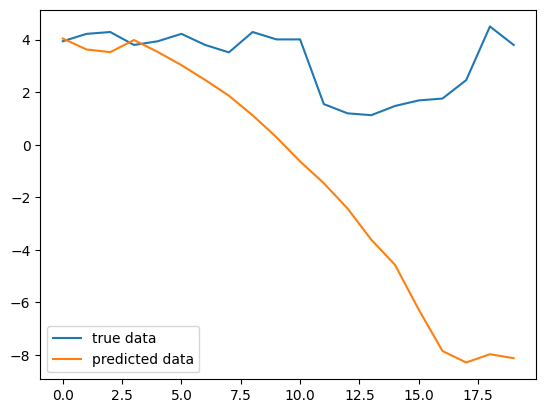

In [24]:
from matplotlib import pyplot as plt
plt_interval = 20
bootstrap = LOOKBACK+1

plt.plot(df.iloc[train_size + bootstrap : train_size+bootstrap+plt_interval , 6].to_numpy(), label="true data")
plt.plot(y_pred_list[bootstrap:bootstrap+plt_interval], label="predicted data")
plt.legend()
plt.show()